In [2]:
import json
import pandas as pd
from numpy import array

import torch
import torch.nn
import torch.optim as optim

# Used in LTSMModel Class Instantiation
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/698")

Found 34 tensors with length 0 at indices: [810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 2460, 2501, 2512, 2583, 5414, 5415, 5416, 5417, 5418, 5419, 5420, 5421, 5422, 5423]


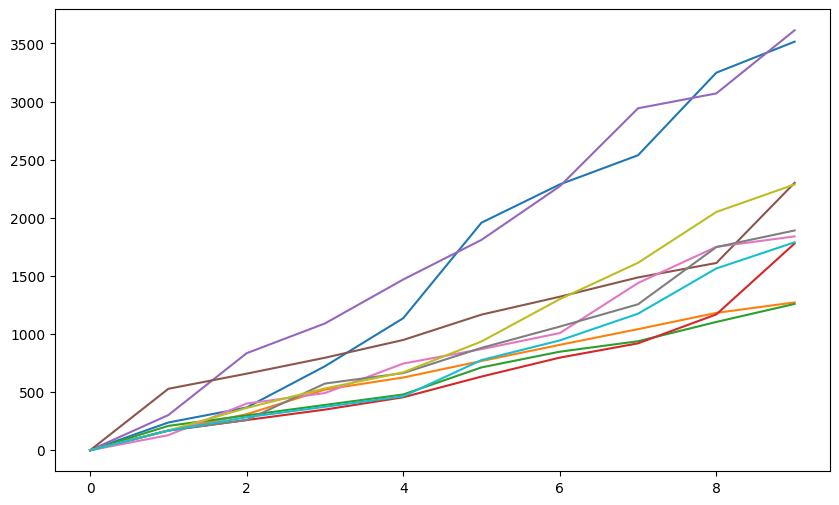

In [5]:
%run data_prep_one_hero.ipynb

In [6]:
#df_allhero[['gold_t']]

#df_allhero[['gold_t']] =

In [7]:
len(df_allhero.iloc[0]['gold_t'])

53

### TimeSeriesDataset Class

In [8]:
type(df_allhero[['gold_t']])

pandas.core.frame.DataFrame

In [9]:
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    # Class to create our dataset
    def __init__(self, df, lookback):
        self.hero_ids = df['hero_id'].values # Declaring hero_id values
        self.time_series = df[['gold_t']]
        #[torch.tensor(ts) for ts in df['gold_t']] # Converting the time_series into Tensors
        self.max_length = max(len(ts) for ts in self.time_series) # Grabs max length of all the tensors to pad them with 0s later
        self.match_ids = df['match_id'] #Storing the match_id in case we want to view this later for more info
        self.lookback = lookback


    def __len__(self):
        return len(self.hero_ids) # Convenient length call


    def create_windows(self, timeseries):
        X, y = [], []
        for i in range(len(timeseries) - self.lookback):
            feature = timeseries[i:i+self.lookback]
            target = timeseries[i+1:i+self.lookback+1]
            X.append(feature)
            y.append(target)


        # print("Create Window X Obj:",X)
        # print("Create Window y Obj:",y)
        # print("Create Window Type X:", type(X))
        # print("Create Window Type y:", type(y))
        #print(len(X))
        #print(len(y))

        X = torch.tensor(X)
        y = torch.tensor(y)
        return X, y



    def __getitem__(self, idx):
        #print("1st Step __getitem__ State: ", idx)
        hero_id = self.hero_ids[idx]

        time_series = np.array(self.time_series.iloc[idx][0]).astype('float32') # Since the df_allhero 'gold_t' column is a column of lists, we take the
        #first row of the df_allhero with .iloc[idx]
        # then we access the the first element of the row, which is the list, with [0]
        # we convert it to a numpy array, and then convert values to float32
        # we do this to be compatible with the ConstantMinMaxScaler()

        match_id = self.match_ids[idx]



        scaled_time_series = ConstantMinMaxScaler(time_series, min_gold, max_gold)
        #print("Type of scaled_time_series:",type(scaled_time_series))
        length = len(scaled_time_series)

        X, y = self.create_windows(scaled_time_series)
        #print(X.shape, y.shape)
        # print("Post create_window:",idx)
        # print("Type of X", type(X))
        # print("Type of y", type(y))



        return hero_id, X, y



### Embedding Layer

Embedding module expects the input tensor to have a shape of (batch_size, sequence_length), where batch_size is the number of samples in a batch and sequence_length is the length of each input sequence

In [10]:
import torch
import torch.nn as nn

class ProcessEmbedding(nn.Module):
    def __init__(self, df, embedding_dim, lookback):
        super(ProcessEmbedding, self).__init__()

        self.num_processes = len(df['hero_id'].unique()) # declaring number of different categories of time-series for dimensionialty reasons
        self.embedding_dim = embedding_dim # passing our embed size to be a class attribute
        self.process_embeddings = nn.Embedding(self.num_processes, embedding_dim)

        self.hero_id_to_idx = {hero_id: idx for idx, hero_id in enumerate(df['hero_id'].unique())}



    def forward(self, hero_id):
        process_ids = self.hero_id_to_idx[hero_id]
        process_ids = torch.tensor([process_ids])
        process_embeddings = self.process_embeddings(process_ids) #.unsqueeze(1).repeat(1, self.lookback, 1)

        # print("Process Embeddings shape:", process_embeddings.shape)
        # print("Process Embeddings tensor:", process_embeddings)

        return process_embeddings


### LSTM

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, process_embedding):
        super(LSTMModel, self).__init__() # ensures the correcty PyTorch class is also initialized

        self.hidden_size = hidden_size #hyper param
        self.num_layers = num_layers #hyper param

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # Actual LSTM creation
        self.fc = nn.Linear(hidden_size, output_size) # Linear Model creation
        self.process_embedding = process_embedding # Process Embedding


    def forward(self, batch):
        #print("LSTM Forward Method Batch Type: ",type(batch))
        # Since our Dataset class returns 3 objects, hero_id, X, y and the forward method only expects two, we have to
        #    tell our forward method to expect one object and unpack it
        hero_ids = batch[0][0] # the _ is a placeholder that doesn't save the last object in the batch which is the y tensor
        X = batch[1][0]
        X = X.unsqueeze(-1) # To match LSTM model's desired shape of (batch_size, seq_length, input_size)

        # print("LSTM Forward Method X Type: ",type(X))
        # print(" LSTM Forward Method - X Shape:", X.shape)
        # print("LSTM Forward Method Tensor X",X)
        # print("LSTM Forward Method hero_ids Type: ",type(hero_ids))
        # print("LSTM Forward Method hero_ids:", hero_ids)

        batch_size = X.size(0) # pulling dims from the tensor
        seq_length = X.size(1) # pulling dims from the tensor

        # print("LSTM Forward Method - batch_size", batch_size)

        # Get process embeddings for hero_ids
        process_embeddings = self.process_embedding(hero_ids)

        # print("LSTM Forward Method - Process Embeddings Shape Pre-Repeat:", process_embeddings.shape)
        # print("LSTM Forward Method - Process Embeddings:", process_embeddings)

        # Reshape process embeddings to match the input shape of LSTM
        # process_embeddings = process_embeddings.unsqueeze(1).repeat(1, seq_length, 1)
        process_embeddings = process_embeddings.repeat(batch_size, seq_length, 1) # changing process embedding shape to broadcast across the same number of samples in the X tensor
        # we do this to match the dimensions so that torch.cat will work
        # print("LSTM Forward Method - Process Embeddings Shape Post-Repeat:", process_embeddings.shape)
        # dim = -1, signifies concatenation across the last dimension (the feature dimension)
        combined_input = torch.cat((X,process_embeddings),dim=-1) #

        # print("Concat'd Time-Series + Embedding shape:", combined_input.shape)

        # Unsqueexing to ensure the time_series shape is 3D like our embedding processing is so that no issues are ran into with torch.cat below
        #time_series = time_series.unsqueeze(-1)

        #print("Time Series shape with extra dimension:", time_series.shape)

        # Concatenate process embeddings with time series data



        # Pack the padded sequences
        # Packing the padded Sequences is a way of optimizing computation times. We have padded the time series to all be the same length, even though some are only 20 or less
        # The packing indicates which are the real values in the time series so that the computation is only ran on those time steps. Details on how are unknown to me thus far.
        #packed_input = pack_padded_sequence(input_data, lengths, batch_first=True, enforce_sorted=False)


        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)


        #packed_output, _ = self.lstm(packed_input, (h0, c0))

        # Unpack the output
        #output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Pass combined input to LSTM layer
        output, _ = self.lstm(combined_input)

        # Take the last output of the LSTM
        out = self.fc(output[:, -1, :])

        return out

### Instantiating Classes and Parameters

In [12]:
lookback = 10
#train_dataset = TimeSeriesDataset(df_allhero, lookback)
process_embedding = ProcessEmbedding(df_allhero, embedding_dim=84, lookback=lookback) # we create the embedding vector on unsplit data to ensure all unique hero id's are contained

input_size = process_embedding.embedding_dim + 1 #84 + 1
hidden_size = 64
num_layers = 2
output_size = 1  # Assuming you want to predict a single value

model = LSTMModel(input_size, hidden_size, num_layers, output_size, process_embedding)

### Train Test Split

In [13]:
# test_size = .30

# train_df, test_df = train_test_split(df_full, test_size=test_size, shuffle=False)



#### Dataset and Data Load

In [14]:
batch_size = 1

train_dataset = TimeSeriesDataset(df_allhero, lookback=lookback)
test_dataset = TimeSeriesDataset(df_allhero_avglen, lookback=lookback)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
# train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_dataset), batch_size=batch_size, shuffle=False)
# test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_dataset), batch_size=batch_size, shuffle=False)


In [15]:
#len(df_allhero.iloc[32]['gold_t'])

In [16]:
# # Iterate over the train_loader until the desired index
# for idx, (hero_ids, X, y) in enumerate(train_loader):
#     print(idx)
#     if idx == 32:
#         print('Gottem')
#         break

In [21]:
# Training loop
num_epochs = 500


# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_test_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    model.train()

    train_loss = 0.0
    print(f"Epoch: {epoch}")

    for batch in train_loader: #for hero_ids, X, y in train_loader:

        hero_ids, X, y = batch #outputs = model(hero_ids, X)
        #print("Training Loop X Type", type(X))
        #print("Training Loop X shape", len(X))
        #print("Training Loop X", X)

        #print("Training Loop Heros Type", type(hero_ids))
        #print("Training Loop Heros shape", len(hero_ids))
        #print("Training Loop Heros", hero_ids)

        X = X[0]
        # print("Training Loop X Type", type(X))
        # print("Training Loop X shape", len(X))
        # print("Training Loop X", X)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch)

        y = y[0]
        # print("Training Loop Y Type", type(y))
        # print("Training Loop Y shape", len(y))
        # print("Training Loop Y", y)

        targets = y[:, -1]  # Assuming you want to predict the last value of each time series
        loss = criterion(outputs.squeeze(), targets.squeeze())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X.size(0)

    train_loss /= len(train_dataset)

    model.eval()
    test_loss = 0.0

    with torch.no_grad():
         for batch in test_loader: #for hero_ids, X, y in test_loader:
            # Forward pass
            hero_ids, X, y = batch
            X = X[0]
            y = y[0]
            outputs = model(batch) # outputs = model(hero_ids, X)
            targets = y[:, -1]  # Assuming you want to predict the last value of each time series
            loss = criterion(outputs.squeeze(), targets.squeeze())

            test_loss += loss.item() * X.size(0)

    test_loss /= len(test_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    if test_loss < best_test_loss:
      best_test_loss = test_loss
      best_model_state = model.state_dict()

    torch.save(best_model_state, 'best_model.pth')

Epoch: 0
Epoch [1/500], Train Loss: 0.0113, Test Loss: 0.0069
Epoch: 1
Epoch [2/500], Train Loss: 0.0158, Test Loss: 0.0094
Epoch: 2
Epoch [3/500], Train Loss: 0.0182, Test Loss: 0.0090
Epoch: 3
Epoch [4/500], Train Loss: 0.0292, Test Loss: 0.0127
Epoch: 4
Epoch [5/500], Train Loss: 0.0225, Test Loss: 0.0118
Epoch: 5
Epoch [6/500], Train Loss: 0.0209, Test Loss: 0.0097
Epoch: 6
Epoch [7/500], Train Loss: 0.0234, Test Loss: 0.0120
Epoch: 7
Epoch [8/500], Train Loss: 0.0168, Test Loss: 0.0119
Epoch: 8
Epoch [9/500], Train Loss: 0.0166, Test Loss: 0.0069
Epoch: 9
Epoch [10/500], Train Loss: 0.0127, Test Loss: 0.0069
Epoch: 10
Epoch [11/500], Train Loss: 0.0102, Test Loss: 0.0052
Epoch: 11
Epoch [12/500], Train Loss: 0.0119, Test Loss: 0.0067
Epoch: 12
Epoch [13/500], Train Loss: 0.0131, Test Loss: 0.0068
Epoch: 13
Epoch [14/500], Train Loss: 0.0113, Test Loss: 0.0141
Epoch: 14
Epoch [15/500], Train Loss: 0.0178, Test Loss: 0.0170
Epoch: 15
Epoch [16/500], Train Loss: 0.0224, Test Loss: 0.

In [22]:
best_model_state = torch.load('best_model.pth')


<All keys matched successfully>

In [23]:
def create_windows(timeseries, lookback):
    X, y = [], []
    for i in range(len(timeseries) - lookback):
        feature = timeseries[i:i+lookback]
        target = timeseries[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)

    X = torch.tensor(X)
    y = torch.tensor(y)
    return X, y

In [27]:
# Assuming you have already trained the model and have the `model` object available
model.load_state_dict(best_model_state)
# Select a specific time series from df_all_remain
index = 8000  # Choose the index of the desired time series
selected_row = df_all_remain.iloc[index]

# Extract the necessary information from the selected row
hero_id = selected_row['hero_id']
time_series = np.array(selected_row['gold_t']).astype('float32')

# Scale the time series using the same scaling function used during training
scaled_time_series = ConstantMinMaxScaler(time_series, min_gold, max_gold)

# Create windows from the scaled time series
X, y = create_windows(scaled_time_series, lookback)

# Convert X and y to tensors
#X = torch.tensor(X)
#y = torch.tensor(y)

# Create a batch with the selected time series
batch = ((hero_id,), (X,), (y,))

# Set the model to evaluation mode
model.eval()

# Disable gradient computation
with torch.no_grad():
    # Forward pass
    outputs = model(batch)

    # Get the predicted values
    predicted = outputs.squeeze().numpy()


#Unscaling values
unscaled_targets = ConstantUnScaler(y[:,-1], min_gold, max_gold)
unscaled_preds = ConstantUnScaler(predicted, min_gold, max_gold)

# Print the predicted values
print("Targets:")
print(y[:,-1])
print("Predicted values:")
print(predicted)

# Print Unscaled Targets
print("Unscaled Targets")
print(unscaled_targets)
print("Unscaled Preds")
print(unscaled_preds)

Targets:
tensor([0.0321, 0.0373, 0.0414, 0.0435, 0.0503, 0.0512, 0.0559, 0.0583, 0.0672,
        0.0721, 0.0768, 0.0806, 0.0833, 0.0903, 0.0919, 0.1000, 0.1037, 0.1081,
        0.1121, 0.1172, 0.1265, 0.1310])
Predicted values:
[0.00633546 0.01139721 0.01460177 0.01863024 0.01978546 0.02699425
 0.02615975 0.0323626  0.03256669 0.04520998 0.04696634 0.05375472
 0.05622616 0.05924296 0.06830516 0.06707089 0.08026823 0.08009522
 0.08717981 0.0893683  0.09592237 0.10747431]
Unscaled Targets
tensor([ 3340.,  3888.,  4316.,  4536.,  5239.,  5334.,  5830.,  6073.,  7004.,
         7514.,  8006.,  8403.,  8682.,  9414.,  9578., 10419., 10810., 11270.,
        11682., 12213., 13180., 13651.])
Unscaled Preds
[  660.  1188.  1522.  1941.  2062.  2813.  2726.  3372.  3394.  4711.
  4894.  5602.  5859.  6174.  7118.  6989.  8365.  8347.  9085.  9313.
  9996. 11200.]


In [28]:
import matplotlib.pyplot as plt

preds_plot = np.ones_like(time_series) * np.nan
preds_plot[lookback:lookback+len(unscaled_preds)] = unscaled_preds
# plot
plt.plot(time_series, label = "Actual Values")
plt.plot(preds_plot, c='r', label = "Forecasting Predictions")
#plt.plot(test_plot, c='g', label = "Test Predictions")

plt.title(f"HeroID:{hero_id} Game Length: {len(time_series)} Minutes, Lookback Window: {lookback}")

# Add a label to the x-axis
plt.xlabel('Timestep (Minute)')

# Add a label to the y-axis
plt.ylabel('Gold')
plt.legend()
plt.show()

In [26]:
import pandas as pd
from sklearn.metrics import mean_squared_error

# Create an empty dataframe to store the average RMSE scores for each hero
df_results_all = pd.DataFrame(columns=['hero_id', 'avg_rmse'])

# Get the unique hero_ids from the dataframe
hero_ids = df_all_remain['hero_id'].unique()

# Loop over each hero_id
for hero_id in hero_ids:
    # Filter the dataframe for the current hero_id
    hero_df = df_all_remain[df_all_remain['hero_id'] == hero_id]

    # Create empty lists to store the unscaled targets and predictions for the current hero
    unscaled_targets_list = []
    unscaled_preds_list = []

    # Loop over each record for the current hero
    for index, row in hero_df.iterrows():
        # Extract the necessary information from the row
        time_series = np.array(row['gold_t']).astype('float32')

        # Scale the time series using the same scaling function used during training
        scaled_time_series = ConstantMinMaxScaler(time_series, min_gold, max_gold)

        # Create windows from the scaled time series
        X, y = create_windows(scaled_time_series, lookback)

        # Create a batch with the selected time series
        batch = ((hero_id,), (X,), (y,))

        # Set the model to evaluation mode
        model.eval()

        # Disable gradient computation
        with torch.no_grad():
            # Forward pass
            outputs = model(batch)

            # Get the predicted values
            predicted = outputs.squeeze().numpy()

        # Unscaling values
        unscaled_target = ConstantUnScaler(y[-1], min_gold, max_gold)
        unscaled_pred = ConstantUnScaler(predicted[-1], min_gold, max_gold)

        # Append the last unscaled target and prediction to the respective lists
        unscaled_targets_list.append(unscaled_target)
        unscaled_preds_list.append(unscaled_pred)

    # Calculate the RMSE for the current hero
    rmse = np.sqrt(mean_squared_error(unscaled_targets_list, unscaled_preds_list))

    # Create a dataframe for the current hero with RMSE value
    df_results_hero = pd.DataFrame({'rmse': [rmse]})

    # Save the dataframe with the hero_id in the name
    df_results_hero.to_csv(f'df_results_{hero_id}.csv', index=False)

    # Append the hero_id and RMSE to the df_results_all dataframe
    df_results_all = df_results_all.append({'hero_id': hero_id, 'avg_rmse': rmse}, ignore_index=True)

# Save the df_results_all dataframe
df_results_all.to_csv('df_results_all.csv', index=False)

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [ ]:
#test = pd.DataFrame(df_allhero[['gold_t']].iloc[0])
#test